In [1]:
cd ..

/home/luke/projects/CS6140-MatchingPursuit


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.dataset_utils import *
from utils.dictionary_generation import *
from utils.matching_pursuit import *
from utils.metrics import *

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML


In [4]:
num_frames = 300

images = loadVideo("dataset/2011_09_26", num_frames)

In [5]:
images = cropImages(images)

print("Num images: ", len(images))
print("Cropped Image size: ", np.shape(images[0]))

Num images:  114
Cropped Image size:  (200, 200)


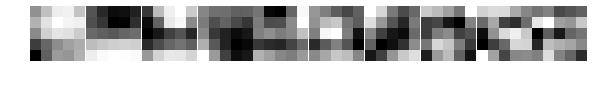

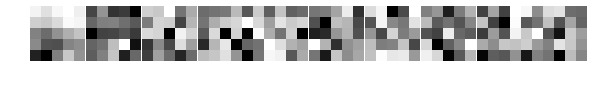

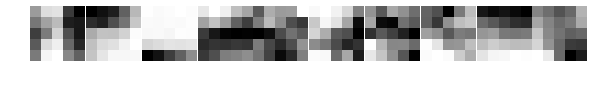

In [10]:
# Generate Dictionaries
patch_size = 5
num_samples = 100
num_features = 10

pca_features = generatePCADictionary(images, patch_size, num_samples, num_features)
optsparse_features = generateOptSparseDictionary(images, patch_size, num_samples, num_features)
kmeans_features = generateKMeansDictionary(images, patch_size, num_samples, num_features)

plotDictionary(pca_features, "PCA")
plotDictionary(optsparse_features, "OptSparse")
plotDictionary(kmeans_features, "KMeans")

In [ ]:
# Experiment 1: Run through video for fixed k and see differences
k = 800

# Test all dicts
pca_code, video_recon_pca = videoMatchingPursuit(images, pca_features, k, greedyMatchingPursuit)
pca_code_optsparse, video_recon_optsparse = videoMatchingPursuit(images, optsparse_features, k, greedyMatchingPursuit)
pca_code_optsparse, video_recon_kmeans = videoMatchingPursuit(images, kmeans_features, k, greedyMatchingPursuit)

# Test all algos
# pca_code_orth, video_recon_orth = videoMatchingPursuit(images, pca_features, k, orthogonalMatchingPursuit)

Number of frames:  114


Number of frames:  114


In [ ]:
# Plot the loss as a function of time
recon_loss_pca = videoLoss(images, video_recon_pca, reconstructionRatio)
recon_loss_optsparse = videoLoss(images, video_recon_optsparse, reconstructionRatio)
recon_loss_kmeans = videoLoss(images, video_recon_kmeans, reconstructionRatio)

plt.plot(np.ones(len(images)), label="Perfect")
plt.plot(recon_loss_pca, label="PCA Greedy")
plt.plot(recon_loss_optsparse, label="Optsparse")
plt.plot(recon_loss_kmeans, label="KMeans")
# plt.plot(recon_loss_pca_orth, label="PCA Orth")

# plt.plot(recon_loss_optsparse, "g", label="OptSparse")
plt.xlabel("Frames")
plt.legend()
plt.title("GMP Reconstruction Fidelity: \nCode Length {}".format(k))
plt.savefig("results/GMP_all_dicts_loss.png")
plt.show()

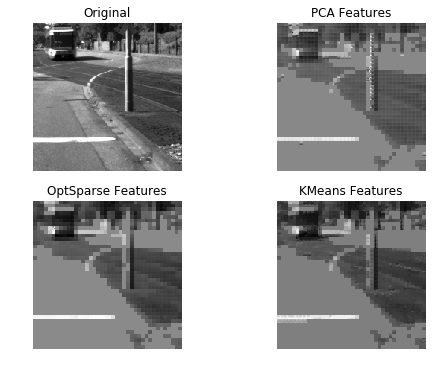

In [36]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,6))
ims = []

ax1.set_title("Original")
ax2.set_title("PCA Features")
ax3.set_title("OptSparse Features")
ax4.set_title("KMeans Features")
for i in range((len(images))):
    im1 = ax1.imshow(images[i], cmap="Greys_r", animated=True)
    im2 = ax2.imshow(video_recon_pca[i], cmap="Greys_r", animated=True)
    im3 = ax3.imshow(video_recon_optsparse[i], cmap="Greys_r", animated=True)
    im4 = ax4.imshow(video_recon_kmeans[i], cmap="Greys_r", animated=True)

    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax4.axis("off")
    ims.append([im1, im2, im3, im4])
    
ani = animation.ArtistAnimation(f, ims, interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())
ani.save('results/GMP_all_dicts_k_{}.gif'.format(k), writer='imagemagick', fps=30)

In [57]:
# Experiment 2: Single image, plot loss against k
K = list(range(20, 800))

recon_img_pca = np.zeros((len(K), images[0].shape[0], images[0].shape[1]))
recon_img_optsparse = np.copy(recon_img_pca)
recon_img_kmeans = np.copy(recon_img_pca)

for i in tqdm(range(len(K))):
    _, recon_img_pca[i] = greedyMatchingPursuit(images[0], pca_features, K[i])
    _, recon_img_optsparse[i] = greedyMatchingPursuit(images[0], optsparse_features, K[i])
    _, recon_img_kmeans[i] = greedyMatchingPursuit(images[0], kmeans_features, K[i])



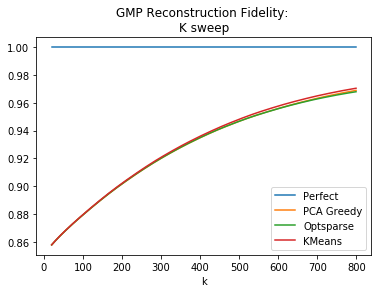

In [58]:
# Plot the loss as a function of time
loss_pca = np.zeros(len(K))
loss_optsparse = np.copy(loss_pca)
loss_kmeans = np.copy(loss_pca)
for i in range(len(K)):
    loss_pca[i] = reconstructionRatio(images[0], recon_img_pca[i])
    loss_optsparse[i] = reconstructionRatio(images[0], recon_img_optsparse[i])
    loss_kmeans[i] = reconstructionRatio(images[0], recon_img_kmeans[i])
    
plt.plot(K,np.ones(len(K)), label="Perfect")
plt.plot(K,loss_pca, label="PCA Greedy")
plt.plot(K,loss_optsparse, label="Optsparse")
plt.plot(K,loss_kmeans, label="KMeans")

plt.xlabel("k")
plt.legend()
plt.title("GMP Reconstruction Fidelity: \nK sweep")
plt.savefig("results/GMP_k_sweep_dicts_loss.png")
plt.show()